# RUL Forecasting 

Metode:

- model: SVR dengan kernel polinomial
- data smoothing menggunakan library tsmoothie

# Import modul

In [1]:
import numpy as np
import pandas as pd
import joblib
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

# Fungsi utility

In [2]:
def get_data():
    df = pd.read_csv("Data Vibrasi Bearing 3.xlsx.csv")
    column_target = "Eng Brg 3X Vibration"
    df = df[column_target]
    return df

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# Preprocessing

In [3]:
data = get_data()
print(f"jumlah data keseluruhan: {len(data)}")

jumlah data keseluruhan: 17520


Amputasi data
---------------------

In [4]:
data = data[4713:10947]
print(data, "\n")
print(f"Jumlah data keseluruhan: {len(data)}")
plt

4713      9.65
4714      9.40
4715      9.14
4716      9.40
4717      9.14
         ...  
10942    21.30
10943    20.80
10944    21.10
10945    20.80
10946    20.60
Name: Eng Brg 3X Vibration, Length: 6234, dtype: float64 

Jumlah data keseluruhan: 6234


<module 'matplotlib.pyplot' from 'C:\\Users\\USER\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Filter data yang kecil dari 7
---------------------------------------

In [5]:
filtered = data[data > 7]
print(filtered)
print(f"Jumlah data setelah fitler: {len(filtered)}")

4713      9.65
4714      9.40
4715      9.14
4716      9.40
4717      9.14
         ...  
10942    21.30
10943    20.80
10944    21.10
10945    20.80
10946    20.60
Name: Eng Brg 3X Vibration, Length: 6116, dtype: float64
Jumlah data setelah fitler: 6116


Simpan data
------------------

In [6]:
df = pd.DataFrame({"data": filtered.to_numpy()})
df.to_csv("bearing-3-extracted.csv", index=False)

# Data Smoothing 

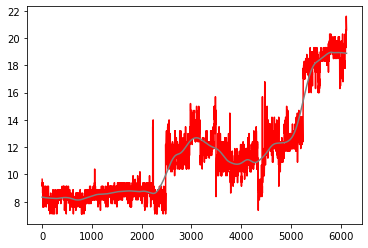

In [7]:
import pandas as pd
from tsmoothie.smoother import DecomposeSmoother, LowessSmoother
import matplotlib.pyplot as plt

smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)

df = pd.read_csv("bearing-3-extracted.csv")
smoother.smooth(df)

plt.plot(df, label="data", c="red")
plt.plot(smoother.smooth_data[0], label="Extracted", c="grey")

# Training

In [8]:
import numpy as np

y = smoother.smooth_data[0]
x = np.array([[i] for i in range(len(y))])

for i in range(100):
    for j in range(5):
        clf_poly = SVR(kernel="poly", degree=2)
        clf_poly.fit(x, y)
        

In [9]:
from joblib import dump
dump(clf_poly, "svr.joblib")

['svr.joblib']

# Cari titik dimana vibrasi > vibrasi TH

In [10]:
TH = 63

x_test = [[i] for i in range(0, len(y)+10000)]

out = clf_poly.predict(x_test)
print(out)

i = 0


for i in x_test:
    t = clf_poly.predict([i])
    
    if t > 63 and t < 64 :
        x_mark = i
        y_mark = t
    

[ 8.08209214  8.08209242  8.08209327 ... 81.79875909 81.80790934
 81.81706015]


In [11]:
RUL_X = [i for i in range(len(x)+10000)]
RUL_Y = [max(y) for i in range(len(y)+10000)]

EOL_Y = np.linspace(0, TH, 1000)
EOL_X = [max(x) for i in range(1000)]

TH_Y = [y_mark for i in range(len(y)+10000)]

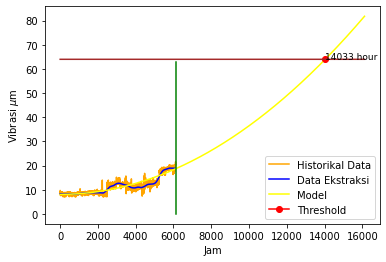

In [12]:
plt.plot(df, label="Historikal Data", c="orange")
plt.plot(smoother.smooth_data[0], label="Data Ekstraksi", c="blue")
plt.plot(x_test, out, label="Model", c="yellow")
plt.plot(x_mark, y_mark, marker="o", c="red", label="Threshold")
plt.plot(EOL_X, EOL_Y, c="green")
plt.plot(RUL_X, TH_Y, c="brown")

# plotting untuk penandaan RUL
plt.text(x_mark[0]+0.8, y_mark[0]+.08, f"{x_mark[0]} hour", fontsize=9)

plt.xlabel("Jam")
plt.ylabel("Vibrasi $\mu$m")
plt.legend()
plt.show()

In [13]:
y_test = smoother.smooth_data[0]
x_test = np.array([[i] for i in range(len(y))])

out = clf_poly.predict(x_test)
regression_results(y_test, out)

explained_variance:  0.8541
mean_squared_log_error:  0.0085
r2:  0.8503
MAE:  0.9602
MSE:  1.5953
RMSE:  1.263
